In [1]:
import matplotlib.pyplot as plt
import json
import itertools
import pandas as pd
import numpy as np

In [2]:
with open('results_test.json') as f:
    data = json.load(f)
    
data_list = []

for run_idx, run in enumerate(data):
        
    for planner_run in run['planner_runs']:
        for ptp_idx, ptp_run in enumerate(planner_run['segments']):
            data_list.append({
                'run_idx': run_idx,
                'ptp_idx': ptp_idx,
                'apples': run['number_of_apples'],
                **planner_run,
                **ptp_run
            })
            
data_df = pd.DataFrame(data_list).sort_values(['run_idx','ptp_idx'])
apples_xyz = pd.DataFrame(data_df['apple'].to_list(), columns=['x','y','z'])

for dim in 'xyz':
    data_df['apple_'+dim] = apples_xyz[dim]
    
data_df['distance_euclidean'] = np.sqrt((data_df[['apple_x','apple_y','apple_z']] - data_df[['apple_x','apple_y','apple_z']].shift(1)).pow(2).sum(axis=1))
data_df.drop(data_df[data_df.ptp_idx == 0].index)

del data_df['apple']
del apples_xyz

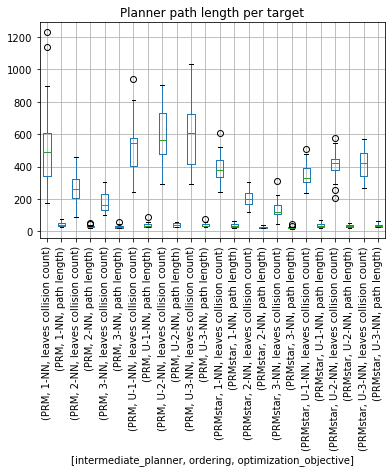

In [11]:
data_df[(data_df.solved) & (data_df.ptp_idx != 0)]\
    .groupby(['intermediate_planner', 'ordering', 'optimization_objective', 'run_idx'])\
    .path_length\
    .mean()\
    .to_frame()\
    .boxplot(by=['intermediate_planner','ordering', 'optimization_objective'], rot=90)

plt.title('Planner path length per target')
plt.suptitle('')
plt.savefig('path_length_per_target.png')
# plt.ylim(0,600)
plt.show()

In [4]:
# data_df[(data_df.solved) & (data_df.ptp_idx != 0)]\
#     .groupby(['intermediate_planner', 'ordering', 'run_idx'])\
#     .unique_leaves_collided\
#     .mean()\
#     .to_frame()\
#     .boxplot(by=['intermediate_planner','ordering'], rot=45)

# plt.title('Unique leaves hit per run')
# plt.suptitle('')
# plt.savefig('leaves_hit_per_target.png')
# plt.show()

In [5]:
by_run = data_df[(data_df.solved) & (data_df.ptp_idx != 0)].groupby(['intermediate_planner', 'ordering', 'run_idx']).first()
(by_run.unique_leaves_collided / by_run.apples).reset_index(['intermediate_planner', 'ordering']).boxplot(by=['intermediate_planner','ordering'], rot=45)

AttributeError: 'DataFrame' object has no attribute 'unique_leaves_collided'

In [ ]:
solved_agg = data_df[(data_df.ptp_idx != 0)].groupby(['intermediate_planner', 'ordering','run_idx']).agg({'solved':'sum','apples':'first'})
solved_agg = solved_agg.groupby(['intermediate_planner', 'ordering']).sum()
solved_proportion = solved_agg.solved / solved_agg.apples
solved_proportion.plot(kind='bar',rot=45,grid=True)

plt.ylim(0.9,1)
plt.title('Proportion of visited targets')
plt.savefig('proportion_visited_targets.png')
plt.show()

In [ ]:
bins = np.linspace(0,100,5)

grouped = data_df.groupby(['intermediate_planner', 'ordering'])

for label, df in grouped:
    if label[0] != 'PRM':
        agg = df.groupby(pd.cut(df.apples, bins)).path_length.agg(['mean','std','count'])
        agg['std_error'] = agg['std'] / np.sqrt(agg['count'])


        agg['mean'].plot(label=label, yerr=1.96 * agg['std_error'])
    
plt.legend(bbox_to_anchor=(1.05, 1))
plt.title("Mean point-to-point path length by total number of apples")
plt.savefig('mean_ptp_length_by_num_apples.png')
ply.ylim(0,60)
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(10,8))
for label, df in data_df.groupby(['intermediate_planner', 'ordering']):
    plt.scatter(df['distance_euclidean'],df['path_length'],label=label,s=1)
    
plt.legend(bbox_to_anchor=(1.05, 1))
plt.title('Path length vs euclidean distance')
plt.ylim(0,100)
plt.show()

In [ ]:
bins = np.linspace(0,100,5)

corr = data_df.groupby(['intermediate_planner', 'ordering',pd.cut(data_df.apples, bins)])[['distance_euclidean','path_length']].corr()
corr = corr.reset_index(3)
corr = corr.path_length[corr.level_3 == 'distance_euclidean']
for label, df in corr.groupby(['intermediate_planner', 'ordering']):
    df.reset_index(['intermediate_planner', 'ordering'], drop=True).plot(label=label)

plt.grid()
plt.ylim(-0.5,0.5)
plt.xlabel('Number of apples')
plt.ylabel('Pearson correlation')
plt.title('Correlation between path lenth and euclidean distance')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

In [ ]:
df = pd.DataFrame(data[0]['leaf_collisions_over_time']).sort_values('t').set_index('t')
(df.new_leaves_in_contact - df.contacts_ended).cumsum().plot()